In [ ]:
!pip install kaggle

In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,ConfusionMatrixDisplay
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)

for filename in os.listdir(path):
    if filename.endswith(".csv"):
        filepath = os.path.join(path, filename)
        try:
            df = pd.read_csv(filepath)
            print(f"Successfully loaded {filename} into a DataFrame.")
            break  # Assuming only one CSV file in the dataset
        except pd.errors.ParserError:
            print(f"Error parsing {filename}. Skipping this file.")
        except Exception as e:
            print(f"An error occurred while loading {filename}: {e}")

# Backup the dataset
df_backup = df.copy()





Path to dataset files: /kaggle/input/creditcardfraud
Successfully loaded creditcard.csv into a DataFrame.


In [ ]:
df = df_backup.copy()

In [ ]:
def is_non_decreasing(data):
    #Check if time is non-decreasing
    for i in range(1, len(data)):
        if data[i] < data[i - 1]:  #Allow equal values, but no decrease
            print(f"Error at {i}: {data[i]} < {data[i-1]}")
            return False
    return True
is_ordered = is_non_decreasing(df['Time'])
print(f"Data is in non-decreasing order: {is_ordered}")

Data is in non-decreasing order: True


In [ ]:
duplicate_values_count = df['Time'].duplicated().sum() #Check for rows with same Time
print(duplicate_values_count)

160215


In [ ]:
duplicate_values_count = df.duplicated(subset=['Time', 'Amount']).sum() #Check for rows with same Time and Amount values
print(duplicate_values_count)


4863


In [ ]:
duplicate_values_count = df.duplicated().sum() #Check for duplicates in general
print(duplicate_values_count)


1081


In [ ]:
df['Time'].dtype

dtype('float64')

In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
df.head(20)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [ ]:
# def add_lag_features(df, n_lags=1, time_col='Time', target_col='Class'):

#     feature_cols = [col for col in df.columns if col not in [time_col, target_col]]

#     #Add lagged features
#     for col in feature_cols:
#         for lag in range(1, n_lags + 1):
#             df[f'{col}_lag{lag}'] = df[col].shift(lag)


#     df = df.dropna().reset_index(drop=True)

#     return df

In [ ]:
df.head(20)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [ ]:
#Plots ACF and PACF for all features except Time and Class to detect patterns in time and dependencies
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf_all(df, lags=40, exclude_cols=['Time', 'Class']):
    features = [col for col in df.columns if col not in exclude_cols]

    for col in features:
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        fig.suptitle(f'ACF and PACF for {col}', fontsize=16)

        plot_acf(df[col], lags=lags, ax=axes[0])
        plot_pacf(df[col], lags=lags, ax=axes[1], method='ywm')

        axes[0].set_title(f'{col} - ACF')
        axes[1].set_title(f'{col} - PACF')
        plt.tight_layout()
        plt.show()


In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

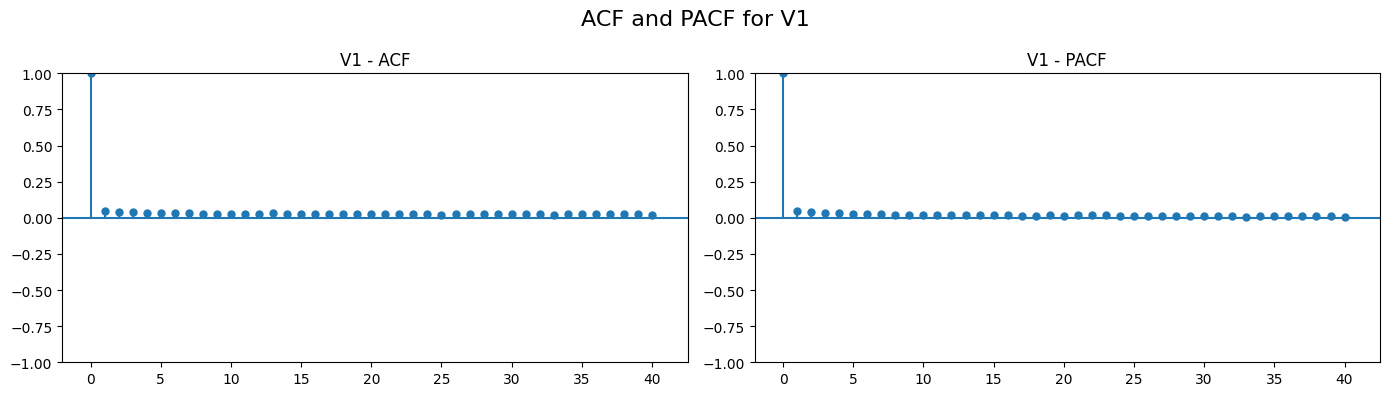

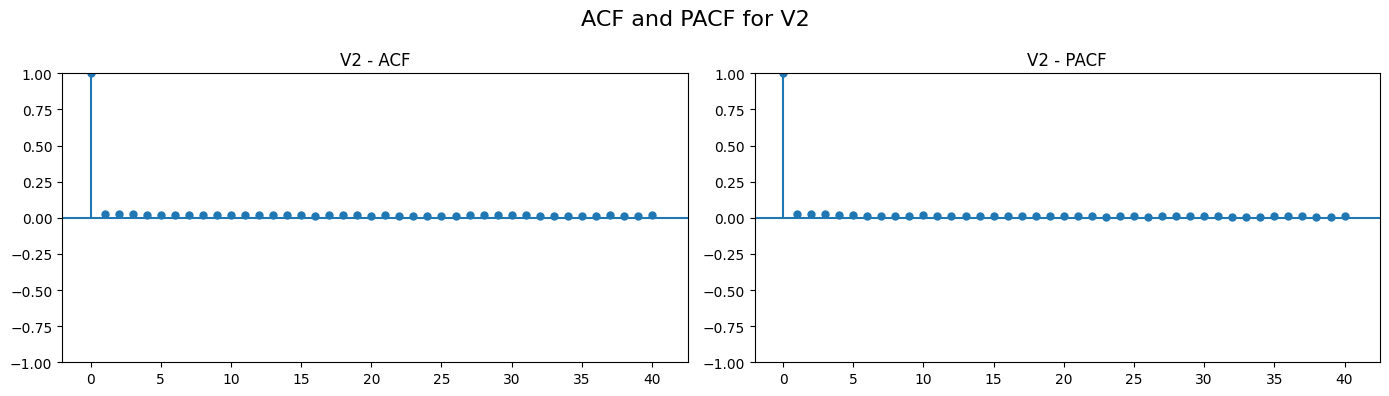

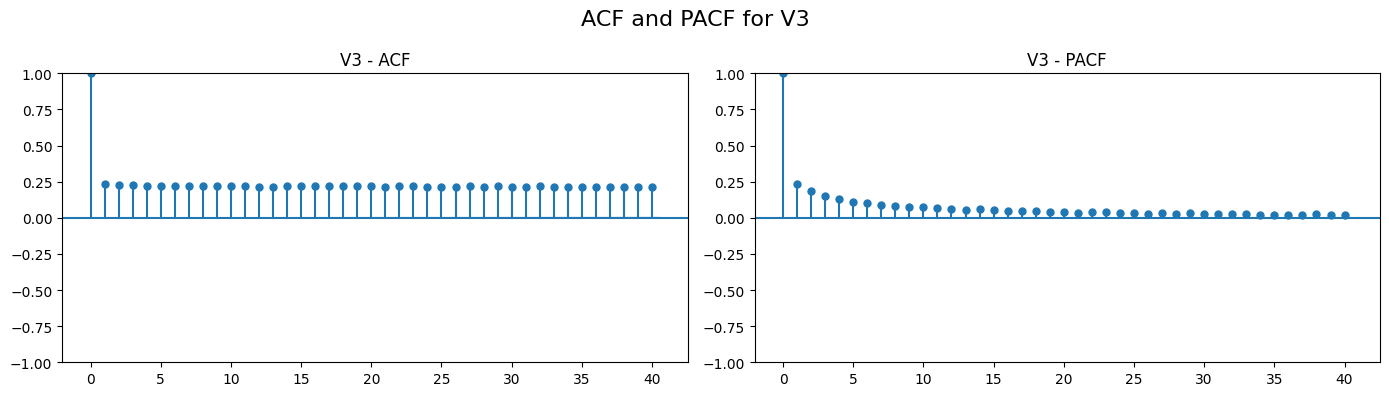

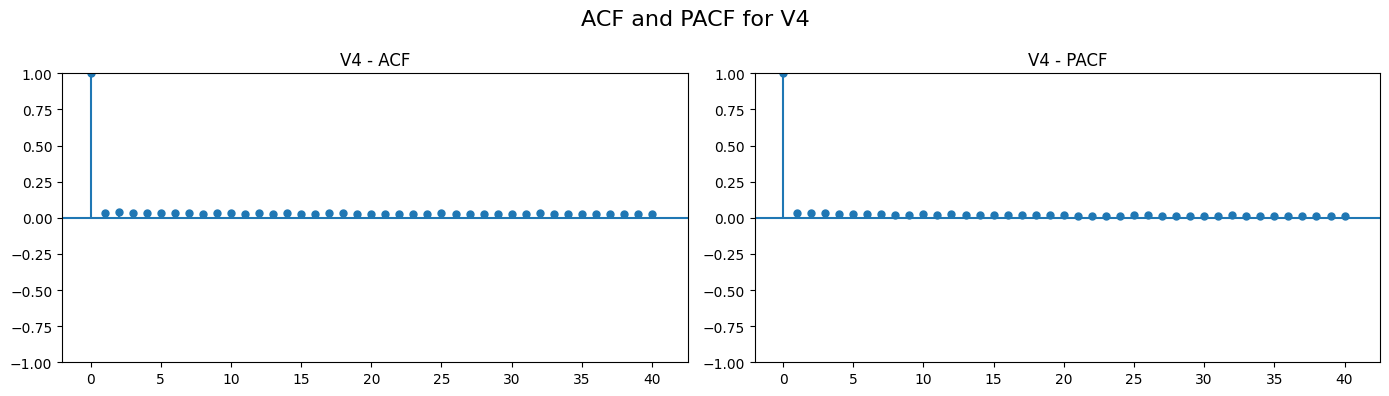

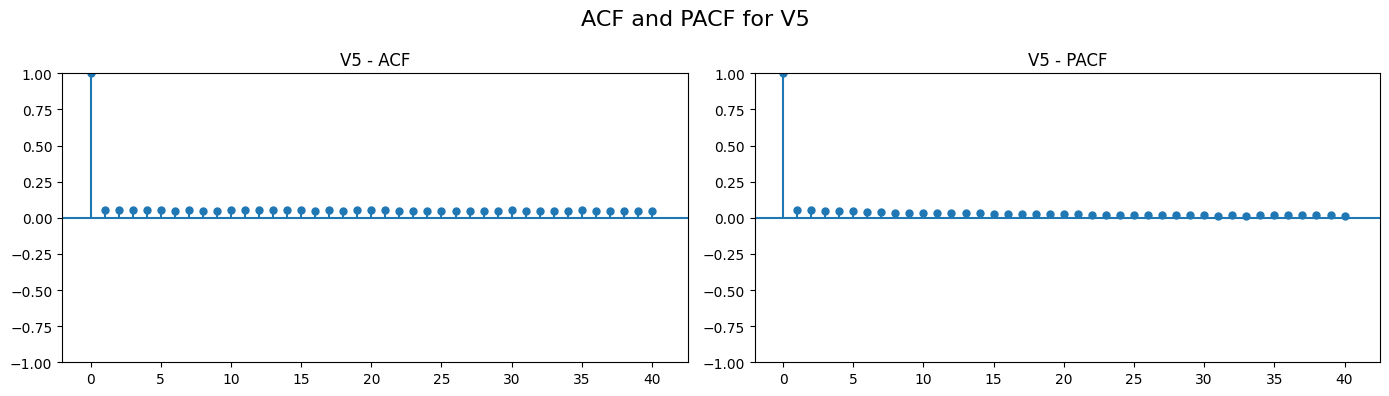

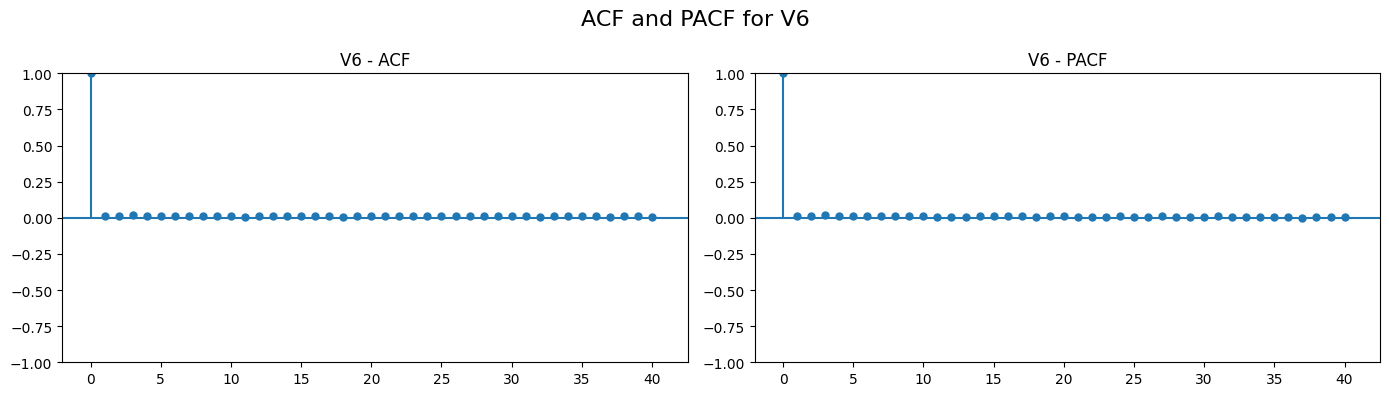

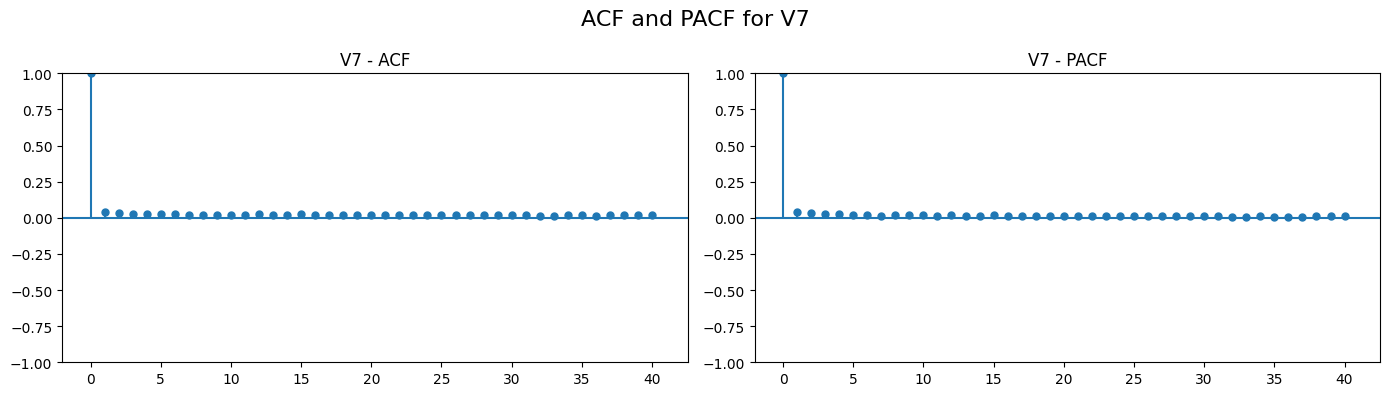

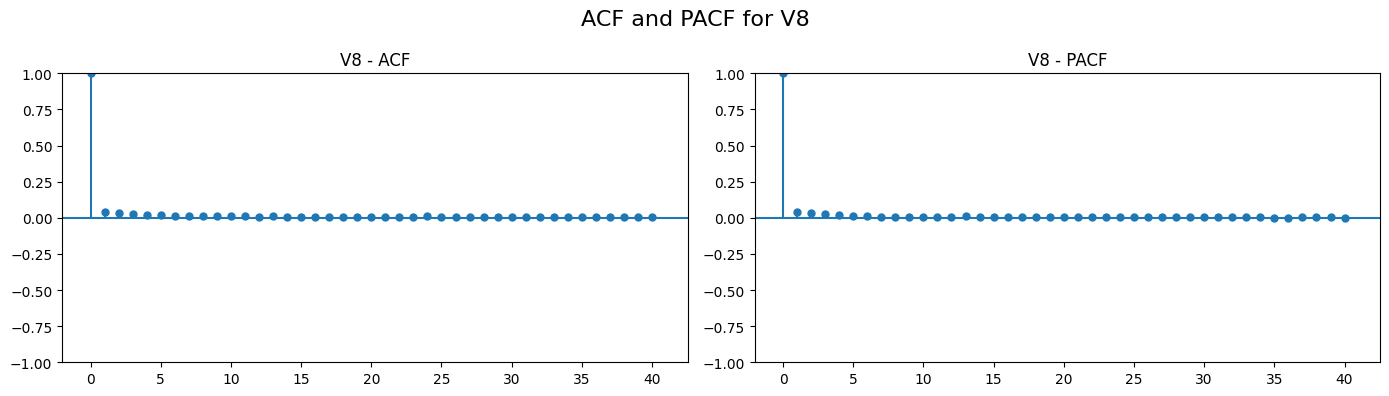

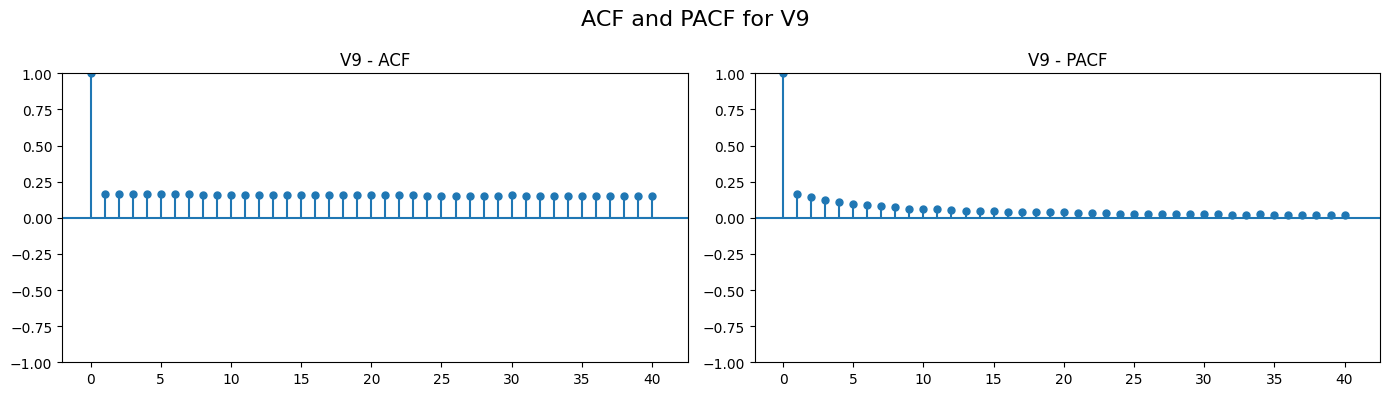

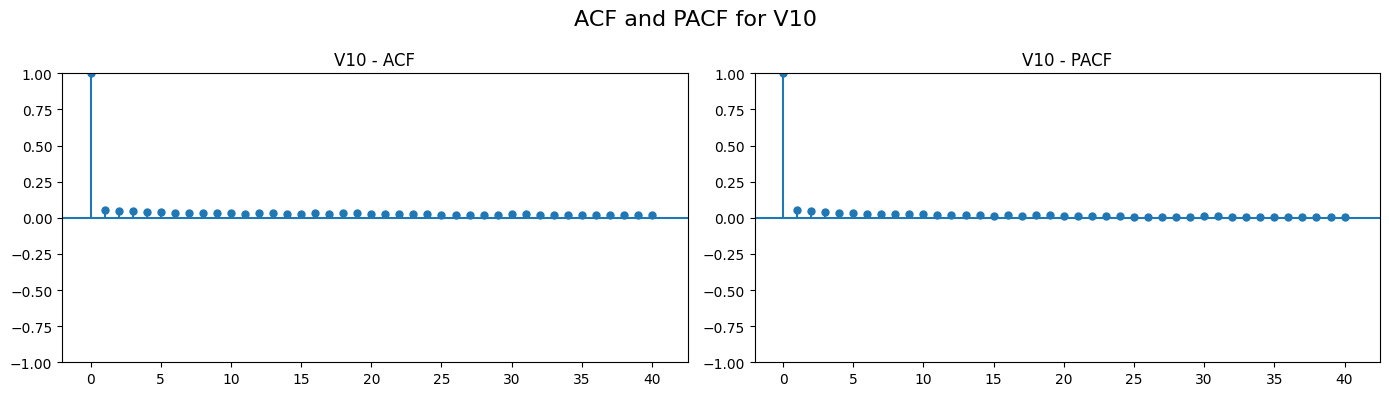

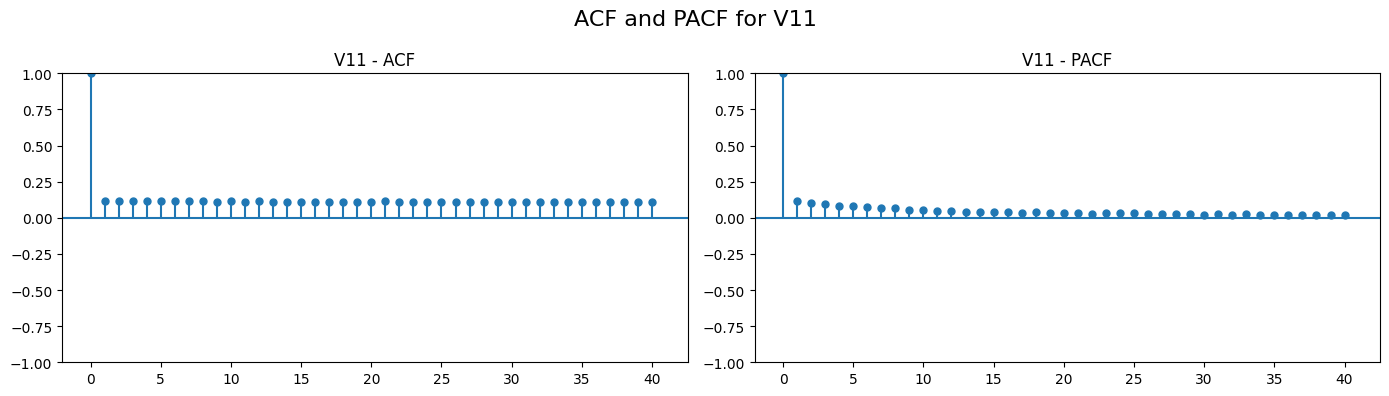

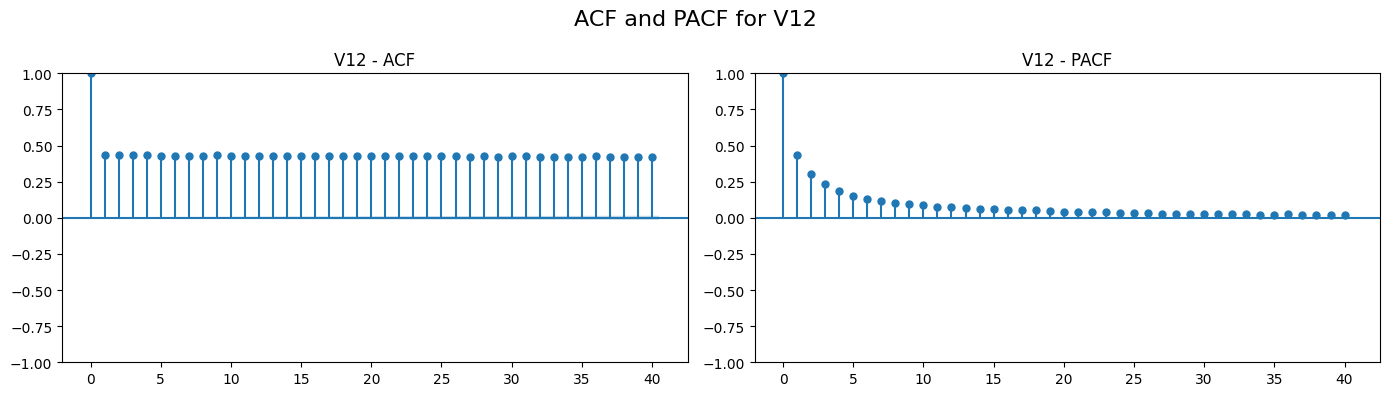

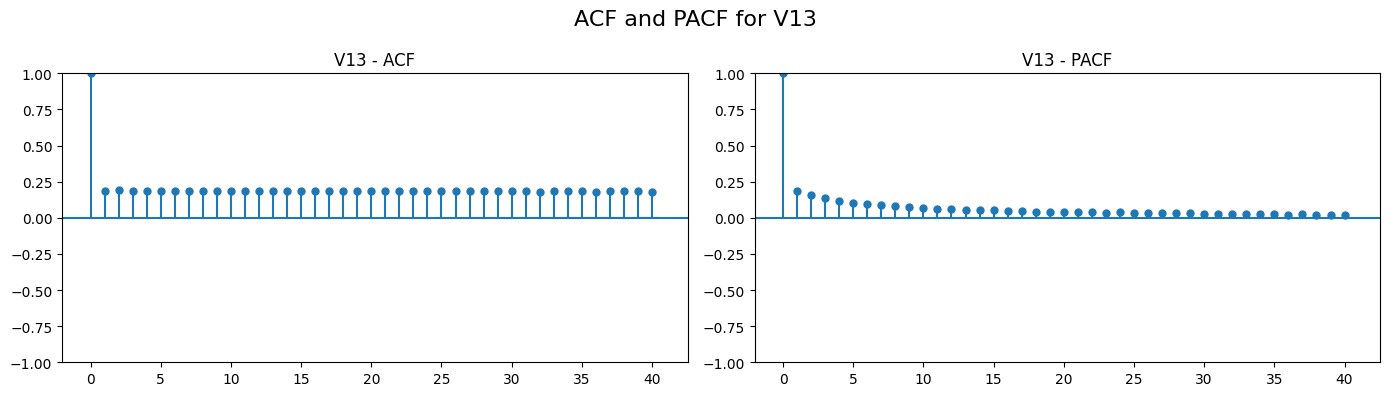

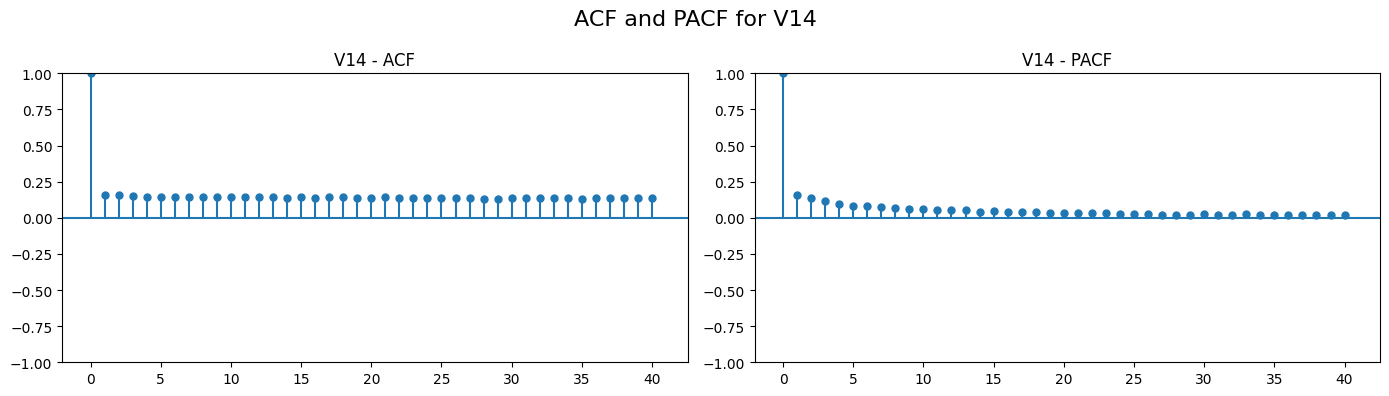

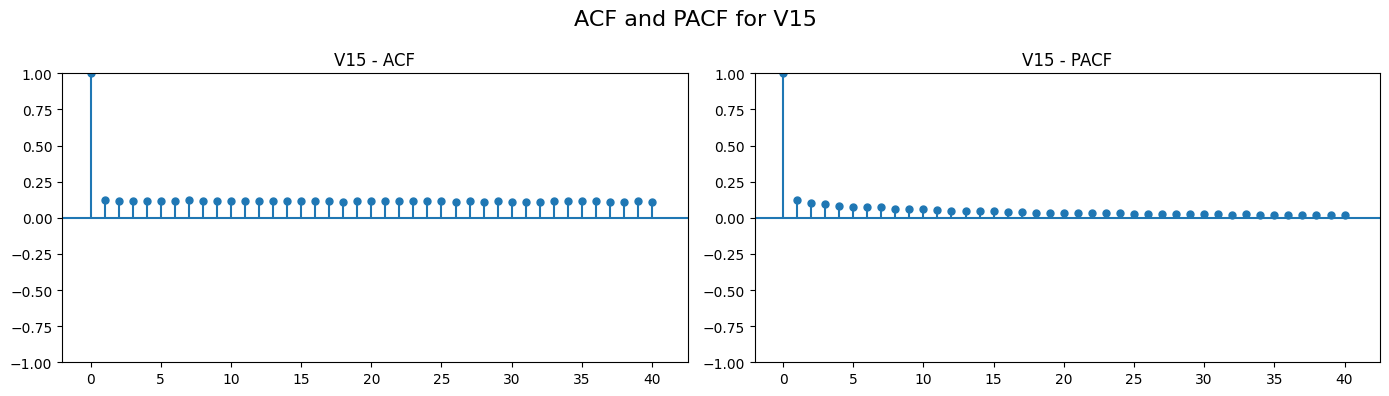

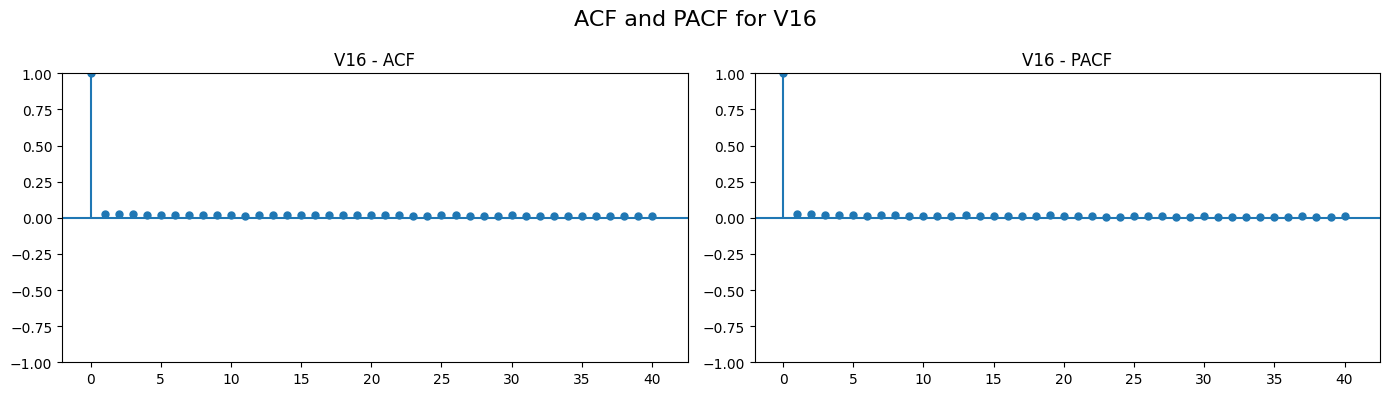

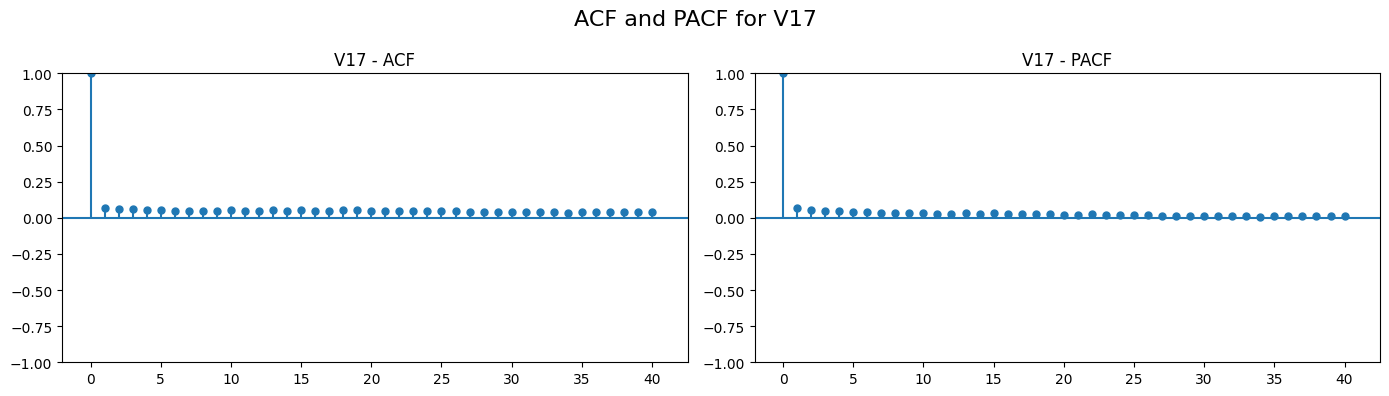

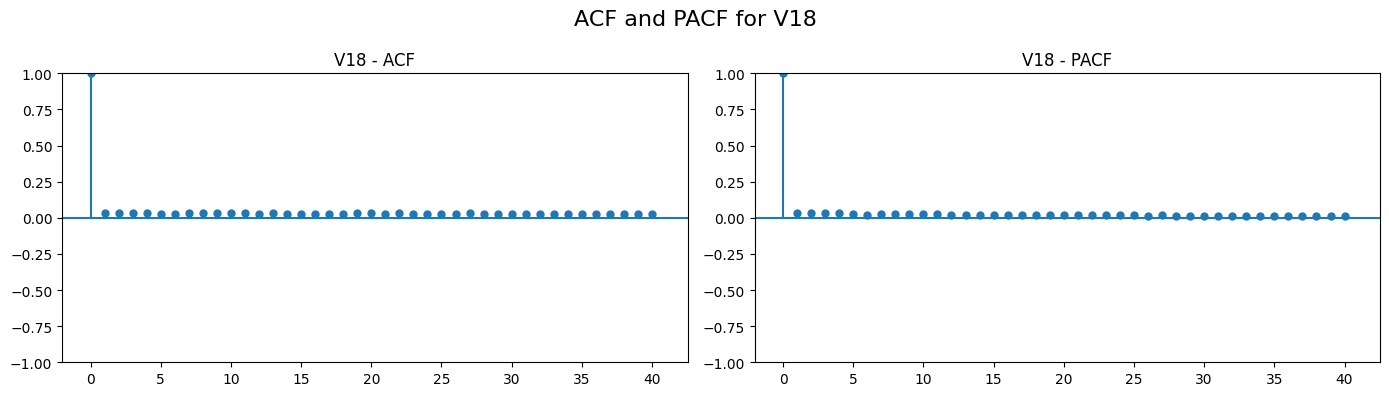

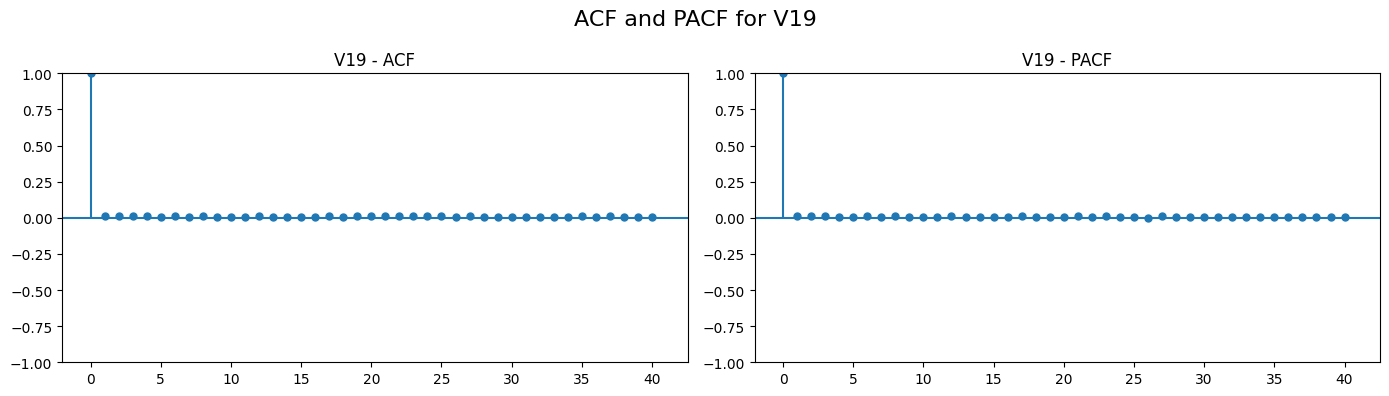

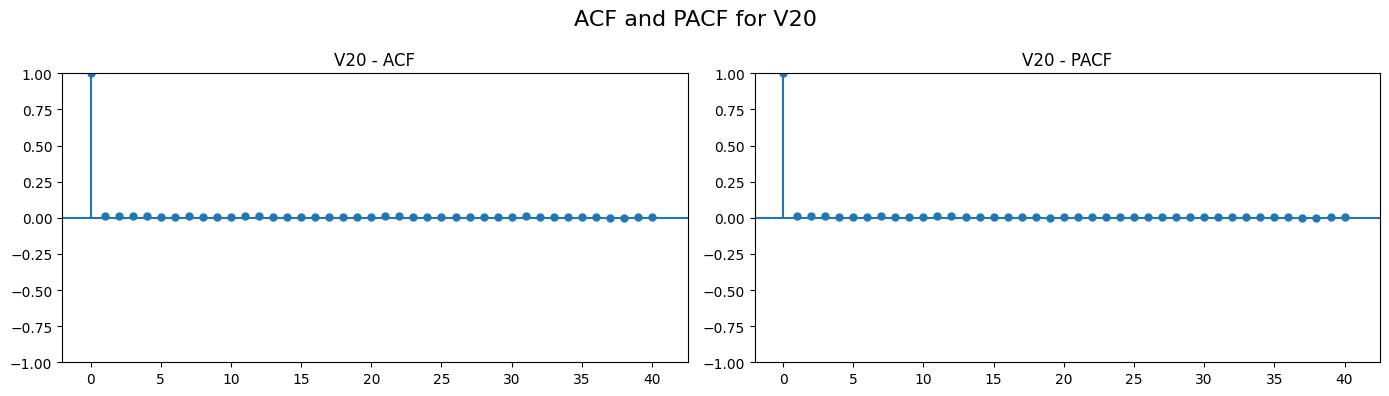

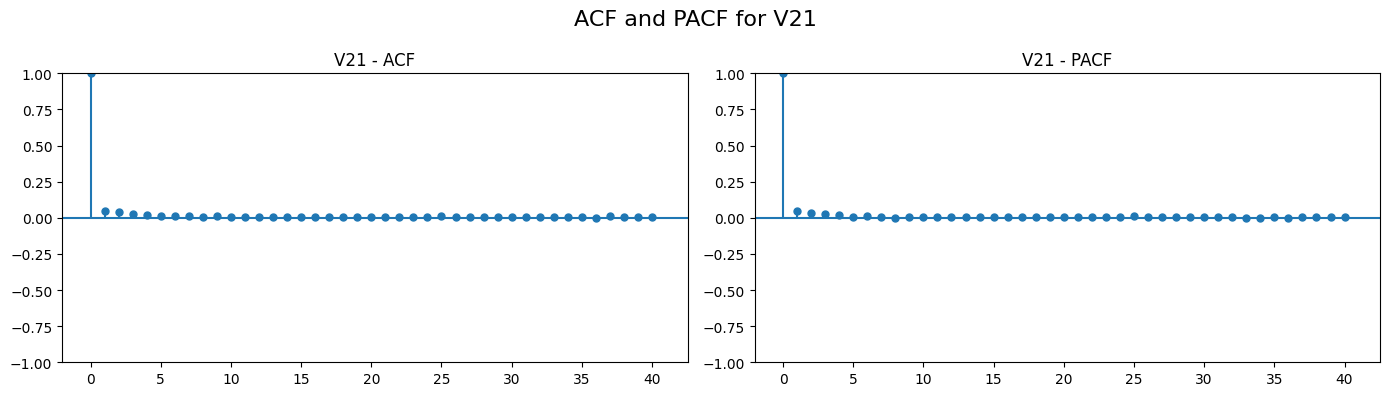

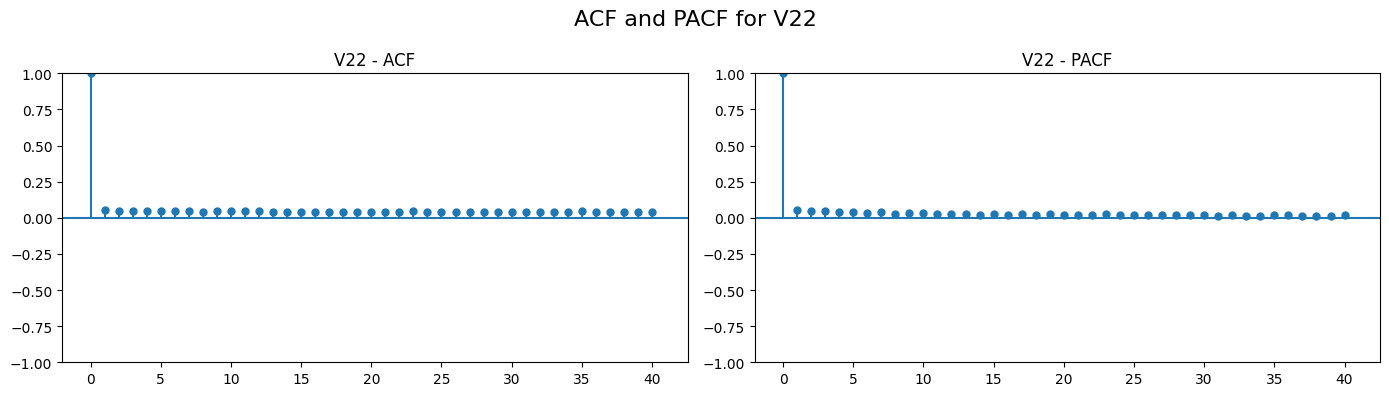

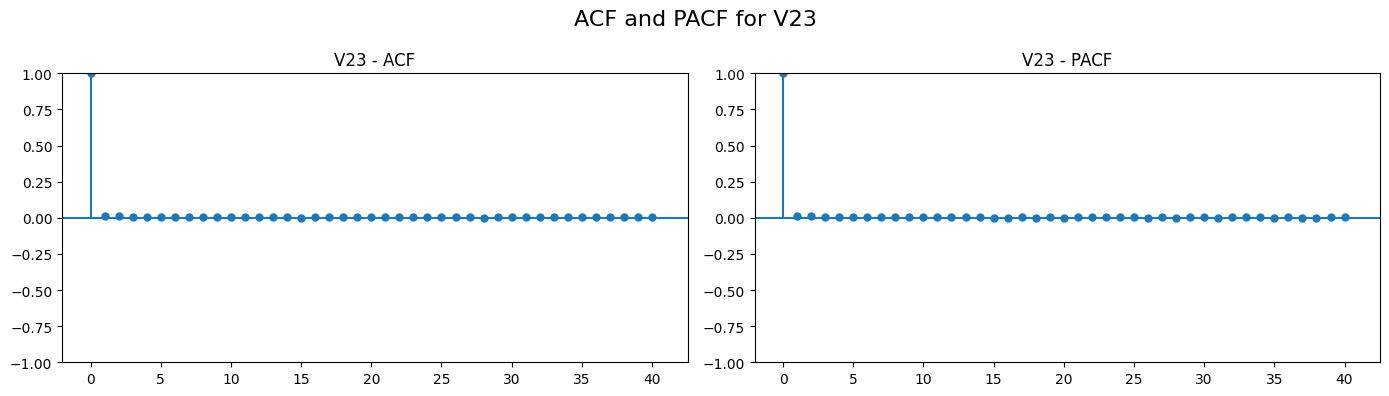

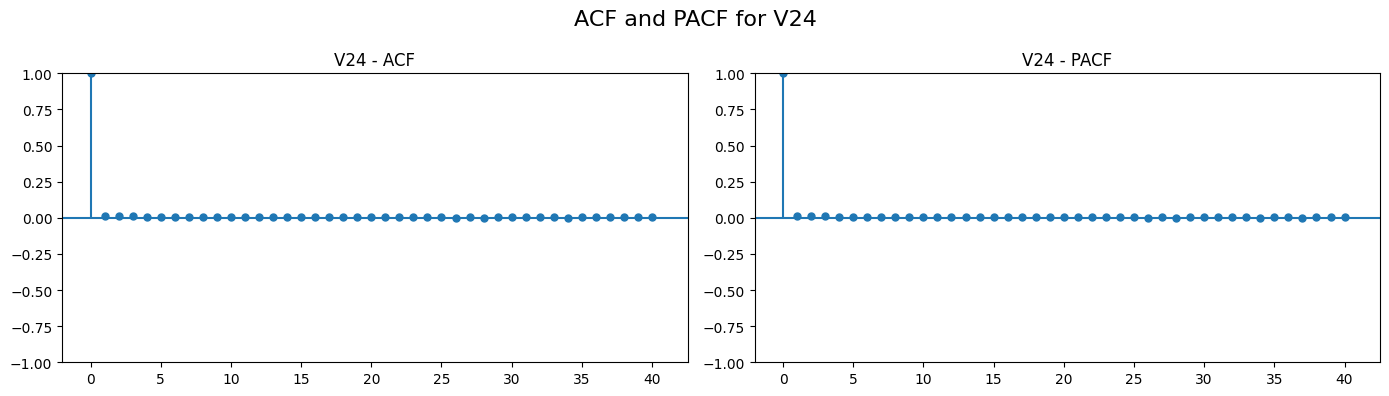

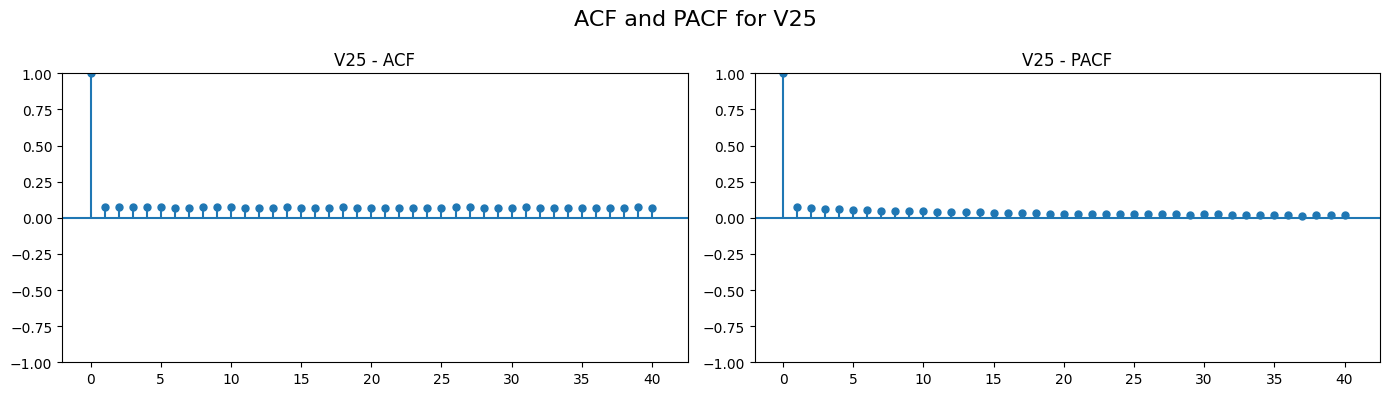

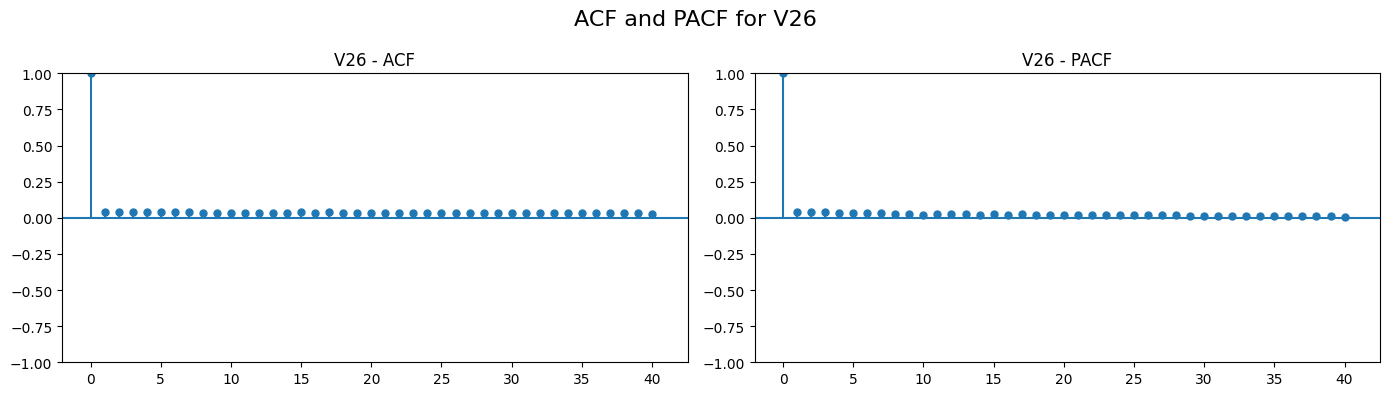

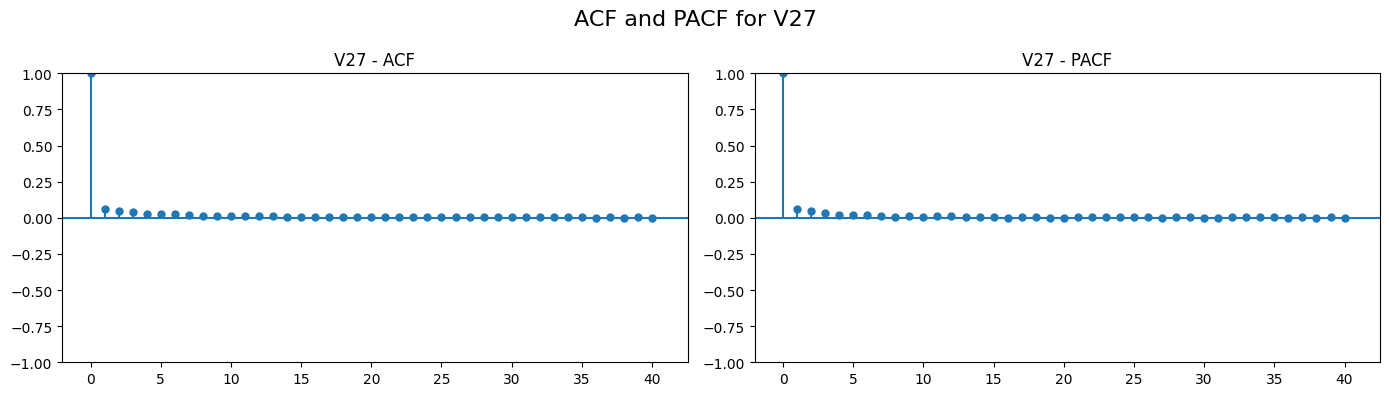

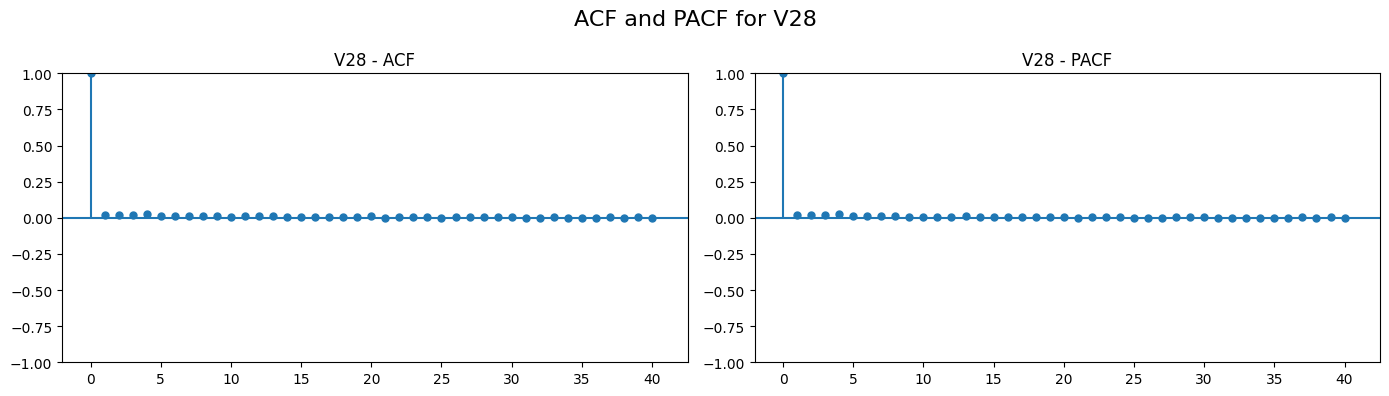

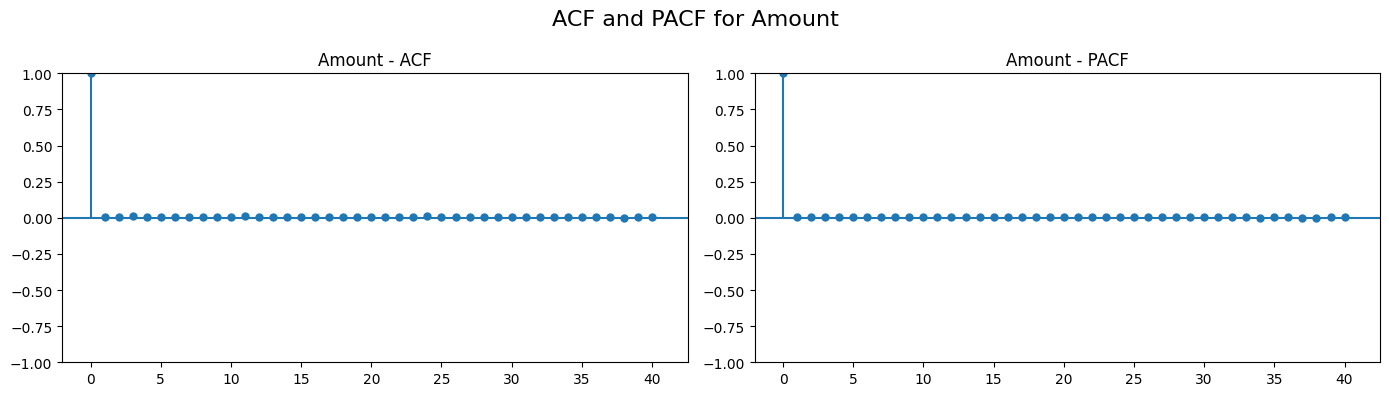

In [ ]:
plot_acf_pacf_all(df)

In [ ]:
#Feature scaling
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

#Define features and target
X = df.drop('Class', axis=1)
y = df['Class']

#Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

In [ ]:
#Function to train, predict, and evaluate the model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Train, predict and evaluate a model."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    #Model evaluation
    print(f"\nEvaluating {model.__class__.__name__}:")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

    #Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    cm_display.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob)}")

    #Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc_score(y_test, y_prob):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

#List of models to evaluate
models = [
    XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    LogisticRegression(max_iter=1000, random_state=42),
    lgb.LGBMClassifier(n_estimators=200, random_state=42),
    #RandomForestClassifier(n_estimators=200, random_state=42)
]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:28:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating XGBClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.96      0.71      0.82        75

    accuracy                           1.00     56962
   macro avg       0.98      0.85      0.91     56962
weighted avg       1.00      1.00      1.00     56962



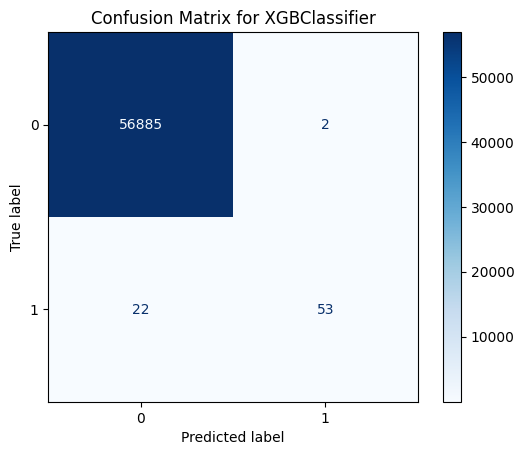

ROC AUC Score: 0.980130434018317

Evaluating LogisticRegression:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.89      0.56      0.69        75

    accuracy                           1.00     56962
   macro avg       0.95      0.78      0.84     56962
weighted avg       1.00      1.00      1.00     56962



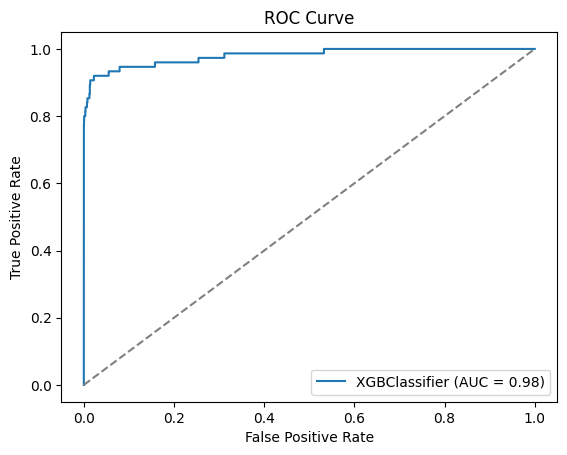

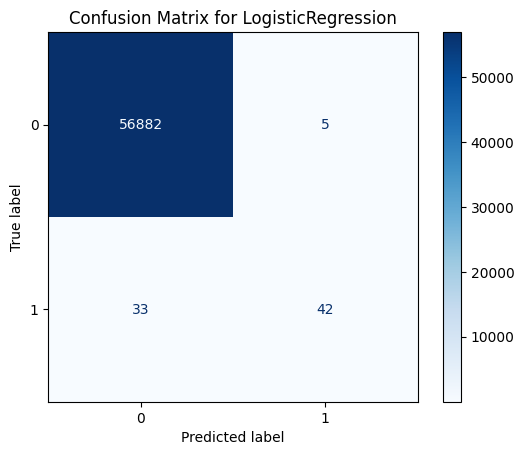

ROC AUC Score: 0.9777512143957905
[LightGBM] [Info] Number of positive: 417, number of negative: 227428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001830 -> initscore=-6.301503
[LightGBM] [Info] Start training from score -6.301503

Evaluating LGBMClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.95      0.28      0.43        75

    accuracy                           1.00     56962
   macro avg       0.98      0.64      0.72     56962
weighted avg       1.00      1.00      1.00     56962



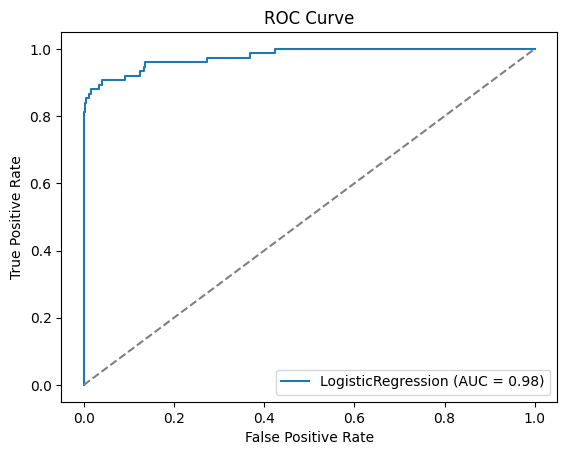

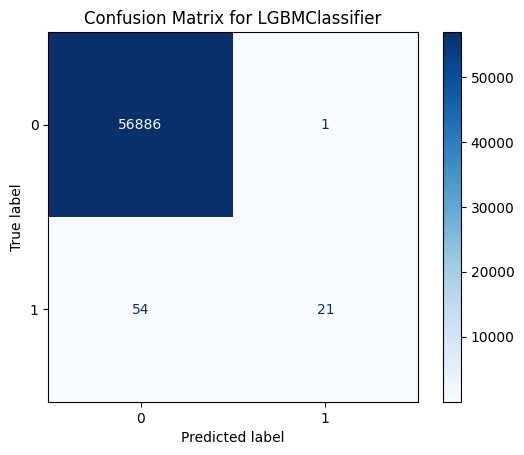

ROC AUC Score: 0.6599846479277632

Evaluating RandomForestClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.98      0.68      0.80        75

    accuracy                           1.00     56962
   macro avg       0.99      0.84      0.90     56962
weighted avg       1.00      1.00      1.00     56962



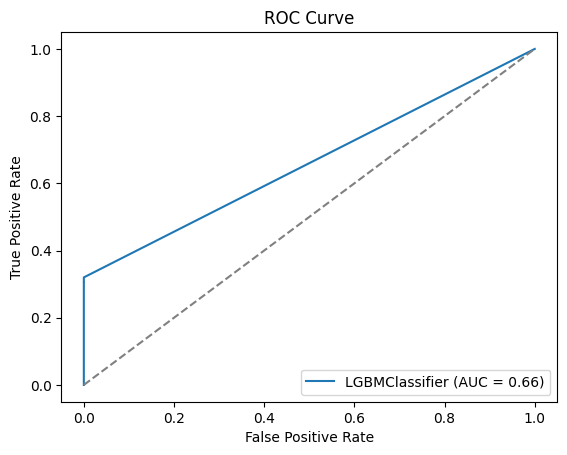

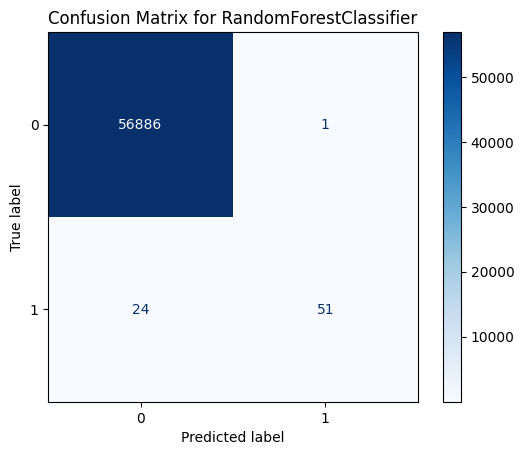

ROC AUC Score: 0.949384335026749


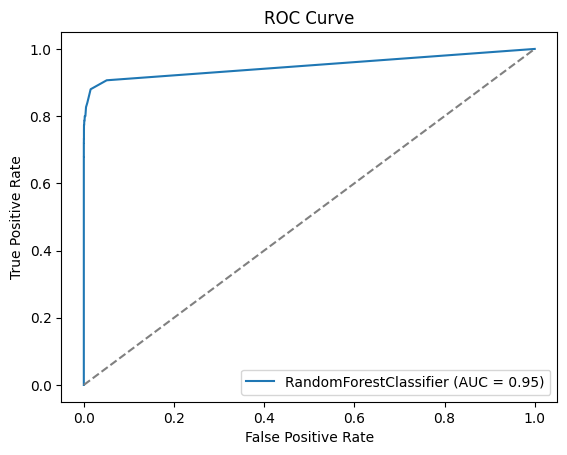

In [ ]:
#Evaluate each model
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

#Display the final plot with all ROC curves
plt.show()


Adding lag features to specific features.

In [ ]:
# def add_custom_lags(df, lag_config):
#     df_copy = df.copy()

#     for col, num_lags in lag_config.items():
#         for lag in range(1, num_lags + 1):
#             df_copy[f"{col}_lag{lag}"] = df_copy[col].shift(lag)

#     return df_copy

# lag_config = {
#     'V3': 3,
#     'V9': 2,
#     'V11': 1,
#     'V12': 3,
#     'V13': 3
# }


In [ ]:
def add_custom_lags_ver2(df, lag_config, y_col='Class', substitute_value=-999):

    df_copy = df.copy()

    #Create lag features
    for col, num_lags in lag_config.items():
        for lag in range(1, num_lags + 1):
            df_copy[f"{col}_lag{lag}"] = df_copy[col].shift(lag)

    #Identify all lag columns
    lag_cols = [f"{col}_lag{lag}" for col, n in lag_config.items() for lag in range(1, n + 1)]

    #Split into positive and negative classes
    positives = df_copy[df_copy[y_col] == 1].copy()
    negatives = df_copy[df_copy[y_col] == 0].copy()

    #Fill nulls in positive class
    positives[lag_cols] = positives[lag_cols].fillna(substitute_value)

    #Drop rows with any NaN in negative class
    negatives = negatives.dropna(subset=lag_cols)

    #Combine back
    df_final = pd.concat([positives, negatives]).sort_index()

    return df_final

lag_config = {
    'V3': 3,
    'V9': 2,
    'V11': 1,
    'V12': 3,
    'V13': 3
}




In [ ]:
df_with_lag_features = add_custom_lags_ver2(df, lag_config)

In [ ]:
df_with_lag_features.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'V3_lag1', 'V3_lag2', 'V3_lag3', 'V9_lag1', 'V9_lag2',
       'V11_lag1', 'V12_lag1', 'V12_lag2', 'V12_lag3', 'V13_lag1', 'V13_lag2',
       'V13_lag3'],
      dtype='object')

In [ ]:
#Feature scaling
scaler = StandardScaler()
df_with_lag_features['Amount'] = scaler.fit_transform(df_with_lag_features['Amount'].values.reshape(-1, 1))
df_with_lag_features['Time'] = scaler.fit_transform(df_with_lag_features['Time'].values.reshape(-1, 1))

#Define features and target
X = df_with_lag_features.drop('Class', axis=1)
y = df_with_lag_features['Class']

#Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:43:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating XGBClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.98      0.73      0.84        75

    accuracy                           1.00     56961
   macro avg       0.99      0.87      0.92     56961
weighted avg       1.00      1.00      1.00     56961



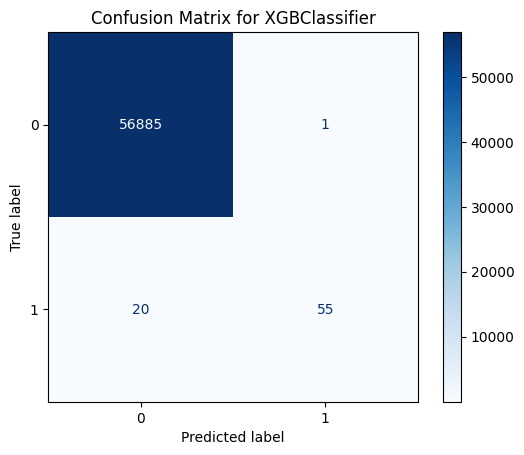

ROC AUC Score: 0.984044111615043

Evaluating LogisticRegression:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.88      0.57      0.69        75

    accuracy                           1.00     56961
   macro avg       0.94      0.79      0.85     56961
weighted avg       1.00      1.00      1.00     56961



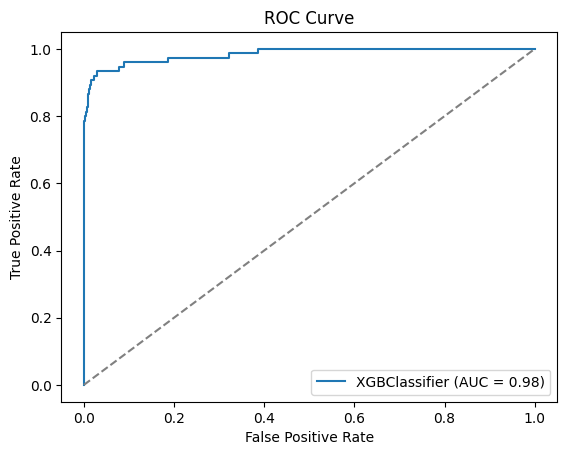

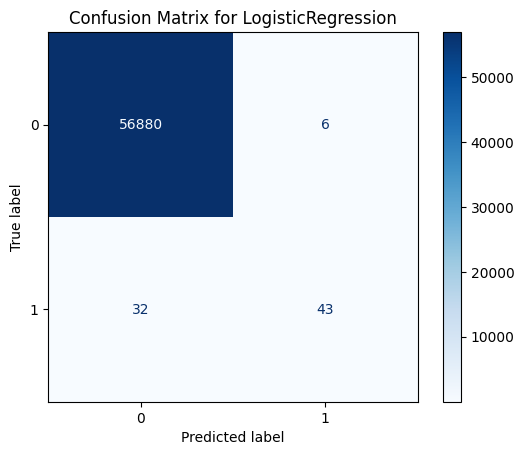

ROC AUC Score: 0.9817522764827902
[LightGBM] [Info] Number of positive: 417, number of negative: 227426
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 227843, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001830 -> initscore=-6.301494
[LightGBM] [Info] Start training from score -6.301494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

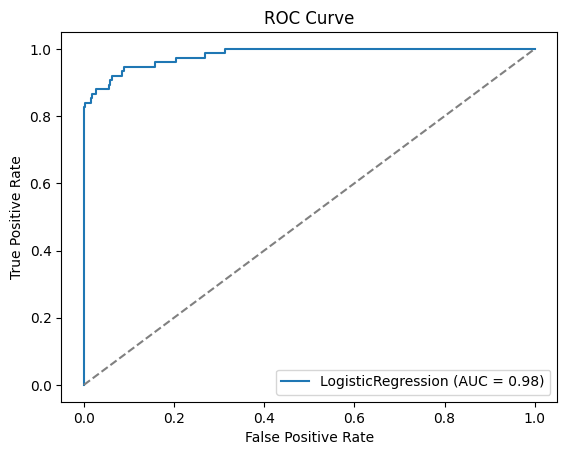

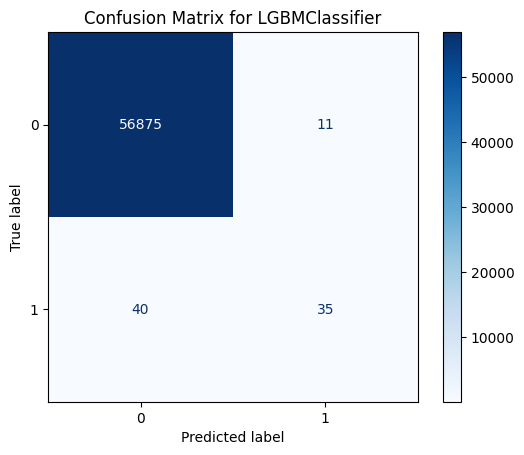

ROC AUC Score: 0.739870032462586


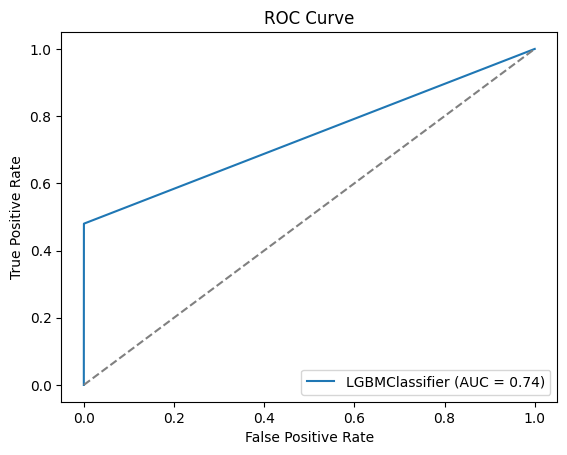

In [ ]:
#Evaluate each model
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

#Display the final plot with all ROC curves
plt.show()

# Adding minute and hour features
Minute and hour features are considered for the potential capturing of temporal patterns.

In [ ]:
print(df)

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.01830

In [ ]:
#Convert to hour (range is 0–23)
df['Hour'] = (df['Time'] // 3600) % 24

#Convert to minute of that hour
df['Minute'] = (df['Time'] // 60) % 60

These features are an attempt to capture how users act at a specific time of day. E.g, transactions occurring during specific hours or minutes may show certain patterns or risks, which can improve the model’s ability to detect underlying trends.



In [ ]:
#Scaling values
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df['Hour'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Minute'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

In [ ]:
#Define features and target
X = df.drop('Class', axis=1)
y = df['Class']

#Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

### Without lag features

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating XGBClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.96      0.71      0.82        75

    accuracy                           1.00     56962
   macro avg       0.98      0.85      0.91     56962
weighted avg       1.00      1.00      1.00     56962



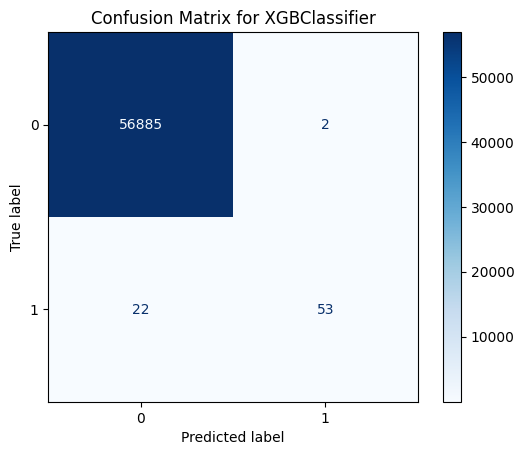

ROC AUC Score: 0.980130434018317

Evaluating LogisticRegression:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.91      0.55      0.68        75

    accuracy                           1.00     56962
   macro avg       0.96      0.77      0.84     56962
weighted avg       1.00      1.00      1.00     56962



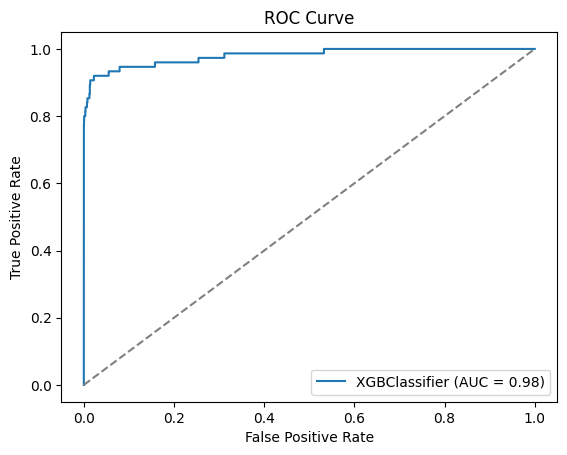

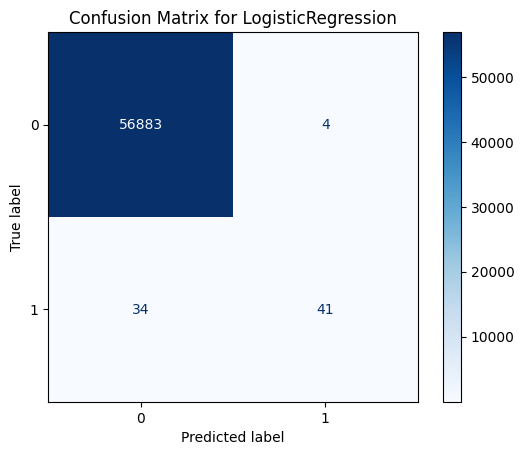

ROC AUC Score: 0.9781545871640269
[LightGBM] [Info] Number of positive: 417, number of negative: 227428
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001830 -> initscore=-6.301503
[LightGBM] [Info] Start training from score -6.301503

Evaluating LGBMClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.95      0.28      0.43        75

    accuracy                           1.00     56962
   macro avg       0.98      0.64      0.72     56962
weighted avg       1.00      1.00      1.00     56962



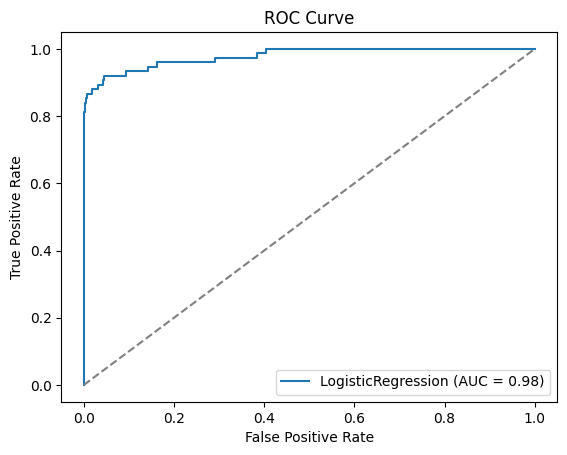

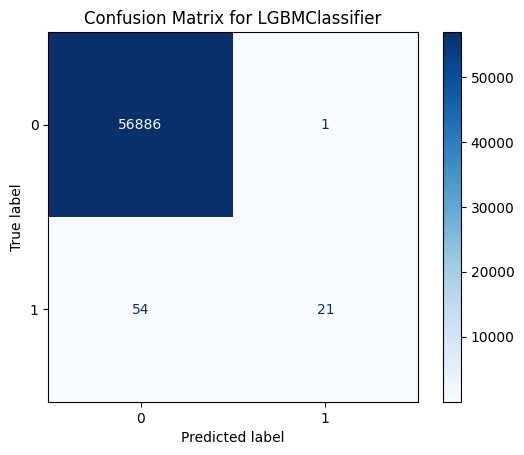

ROC AUC Score: 0.6599846479277632


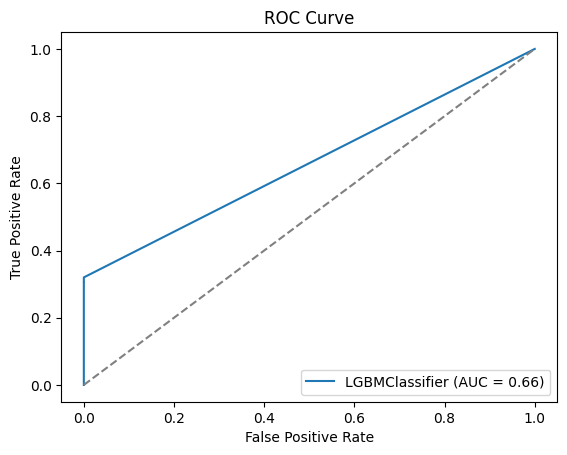

In [ ]:
#Evaluate each model
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

#Display the final plot with all ROC curves
plt.show()

### With lag features

In [ ]:
df_with_lag_features = add_custom_lags_ver2(df, lag_config)

In [ ]:
#Define features and target
X = df_with_lag_features.drop('Class', axis=1)
y = df_with_lag_features['Class']

#Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:02:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating XGBClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.98      0.73      0.84        75

    accuracy                           1.00     56961
   macro avg       0.99      0.87      0.92     56961
weighted avg       1.00      1.00      1.00     56961



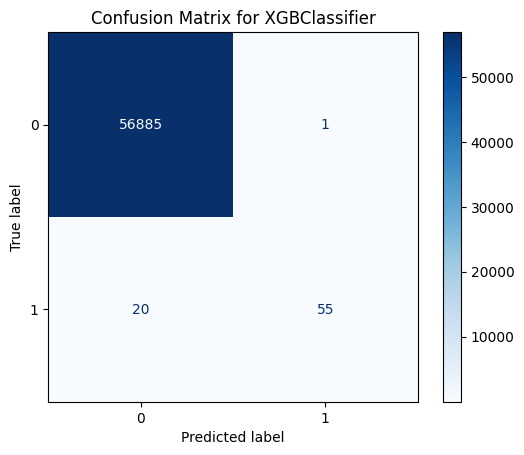

ROC AUC Score: 0.984044111615043

Evaluating LogisticRegression:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.95      0.56      0.71        75

    accuracy                           1.00     56961
   macro avg       0.98      0.78      0.85     56961
weighted avg       1.00      1.00      1.00     56961



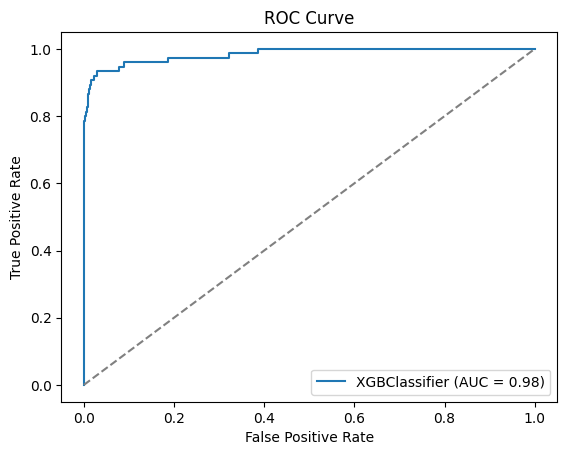

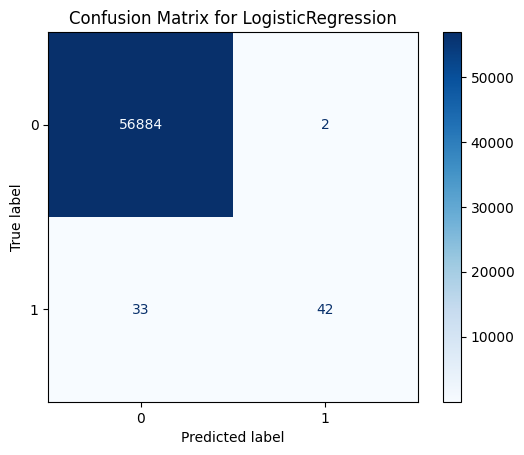

ROC AUC Score: 0.9815235148659893
[LightGBM] [Info] Number of positive: 417, number of negative: 227426
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11220
[LightGBM] [Info] Number of data points in the train set: 227843, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001830 -> initscore=-6.301494
[LightGBM] [Info] Start training from score -6.301494

Evaluating LGBMClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.09      0.29      0.14        75

    accuracy                           1.00     56961
   macro avg       0.54      0.64      0.57     56961
weighted avg       1.00      1.00      1.00     56961



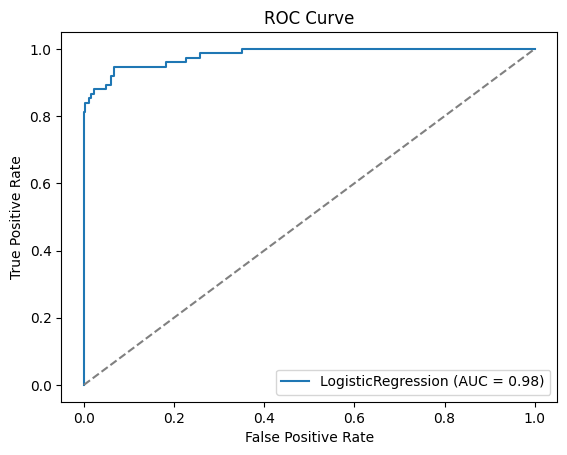

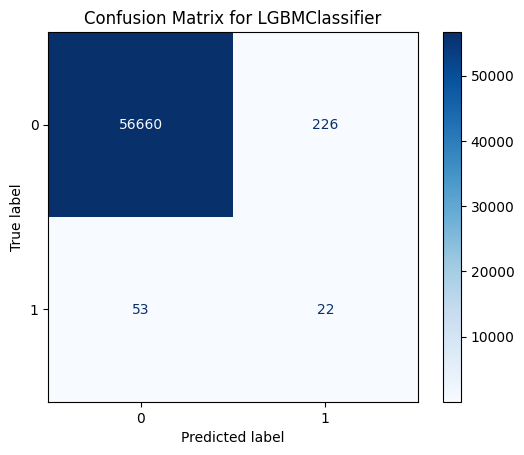

ROC AUC Score: 0.6443764722427311


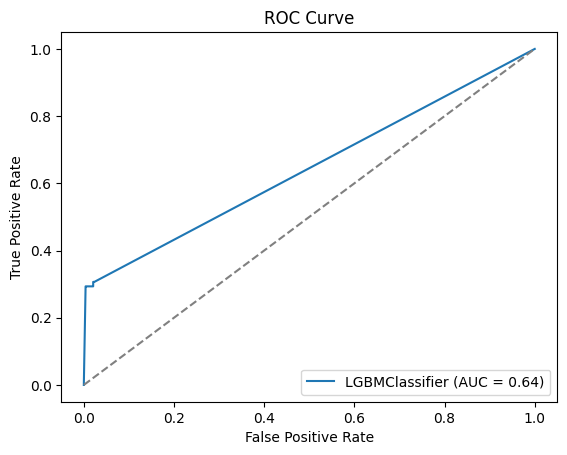

In [ ]:
#Evaluate each model
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

#Display the final plot with all ROC curves
plt.show()